<div style="padding: 10px; border-radius: 5px; text-align: center;">
    <h1>Data Challenge - Kernel Methods</h1>
    <h3>Nils Baillie and Abdoul-Hakim Ahamada</h3>
    <h4>M2 MVA, ENS Paris-Saclay</h4>
</div>

*Total execution time: 50min*

In [1]:
import os
import random
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import cvxopt

from importlib import reload
import methods
reload(methods)
from methods import *

warnings.simplefilter("ignore")
seed()

# Introduction

In this project, we explore the effectiveness of kernel methods for classification tasks involving non-linear data relationships. We consider well-known techniques such as Kernel Ridge Regression (KRR), Kernel Logistic Regression (KLR), Kernel k Nearest Neighbors (KNN), and Support Vector Machines (SVM). By optimizing hyperparameters and analyzing resulting scores, our objective is to gain insights into how these methods perform and their suitability for image classification tasks.

# 1. Data

The dataset consists of two main components: training data (`Xtr.csv` and `Ytr.csv`) and test data (`Xte.csv`). 

- The file `Xtr.csv` contains a matrix with dimensions $5000 \times 3072$, representing color images. Each row corresponds to an image, with each image having a size of $32 \times 32$ pixels. The pixel intensities for each image are organized as follows: the first $1024$ values represent the red channel, the next $1024$ values represent the green channel, and the last $1024$ values represent the blue channel. 
- Similarly, the file `Xte.csv` contains $2000$ test images. Each row in this file corresponds to an image, with the first row representing image $Id=1$ and the last row representing image $Id=2000$.
- Finally, the file `Ytr.csv` contains a vector of labels corresponding to the training data. These labels are essential for training and evaluating classification models on the provided dataset.

To ensure proper data interpretation, visualizing a subset of these images would be beneficial.

*Note: It's important to note that these images have undergone preprocessing, and may not appear as natural images.*

## 1.1. Visualization

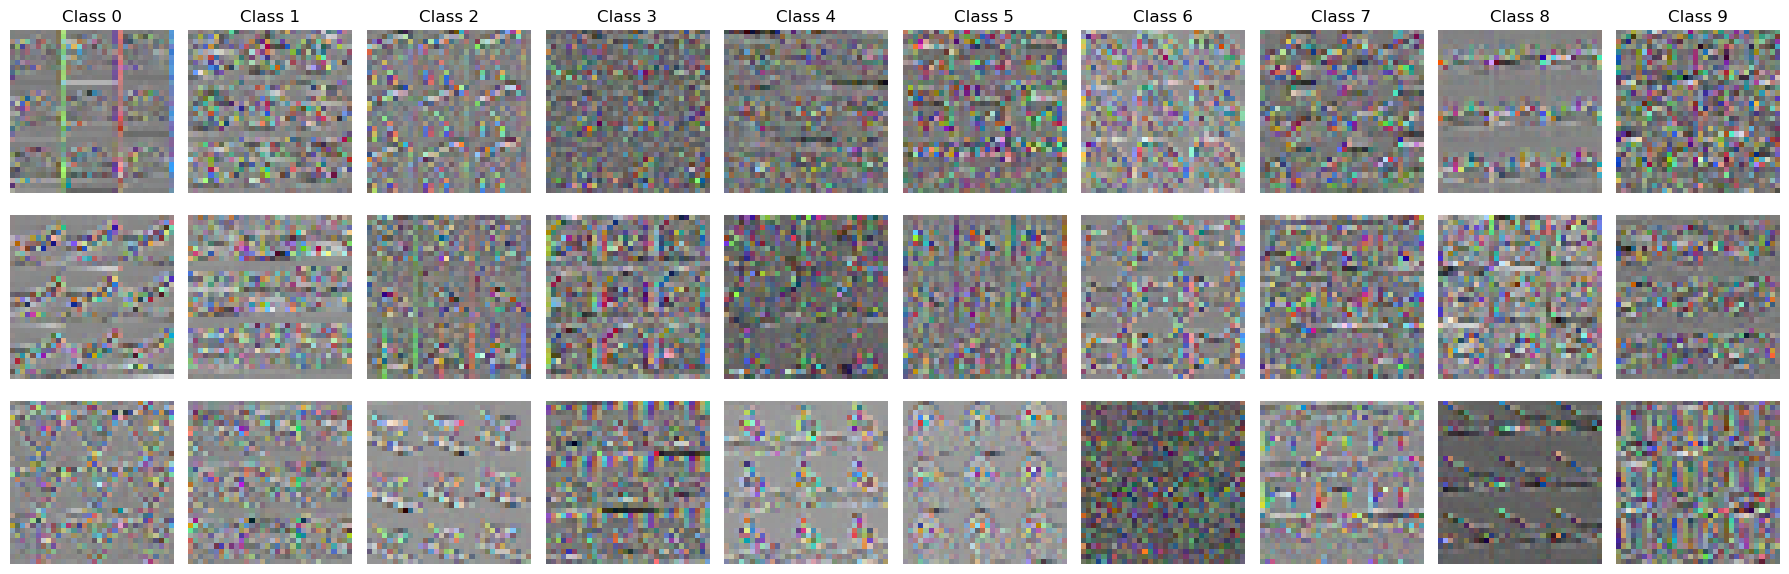

In [2]:
Xtr, Xte, Ytr = load_data()
plot_images(Xtr, Ytr)

## 1.2. Feature extraction

In image classification tasks, raw pixel data alone may not provide sufficient information for accurate classification due to its representation of low-level features like color intensity, which may not effectively capture underlying patterns. Therefore, feature extraction is crucial to transform raw pixel data into a more informative representation. This process aims to capture relevant information such as edges, textures, shapes, or patterns present in the images. Extracting these features can reduce data dimensionality in some cases while preserving important information, leading to improved classification performance by providing algorithms with more discriminative features to learn from.

### 1.2.1. Convolution x Pooling (2D)

To enhance the extraction of features from images and improve classification accuracy, we turned to Convolutional Neural Networks (CNNs) for inspiration. CNNs employ techniques such as convolution and pooling, which help in capturing essential patterns and characteristics from images.

Our initial approach involved the use of the `FeatureExtractor2D` class. This class performs feature extraction in 2D, leveraging methods like convolution and pooling to transform raw pixel data into more informative representations. The `convolve2d` method slides filters over input images, computing dot products with overlapping regions to capture patterns effectively. On the other hand, the `max_pooling` method reduces spatial dimensions by selecting the maximum value within pooling windows. Through a `forward_pass`, these methods collectively create a feature vector representing each image.

Then, the `data_features` function utilizes the `FeatureExtractor2D` class to extract features from input images. Additionally, when `load` is set to `True`, it loads precomputed features from files to expedite the process.

In [3]:
#Xtr_features, Xte_features = data_features(Xtr, Xte, load=False)
Xtr_features, Xte_features = data_features(Xtr, Xte)

While the resulting features cannot be directly interpreted as images, we visualized them to observe the modifications made to the original images and to identify consistent patterns within the same class.

*Note: These features serve as abstract representations of the input images, capturing broader patterns and characteristics rather than individual pixel details. Unlike the original images, which are grids of pixel intensities, the extracted features are usually in the form of feature vectors. These vectors encode important information about the images in a numerical format. Consequently, they cannot be directly visualized as images in the same manner as the original input data.*

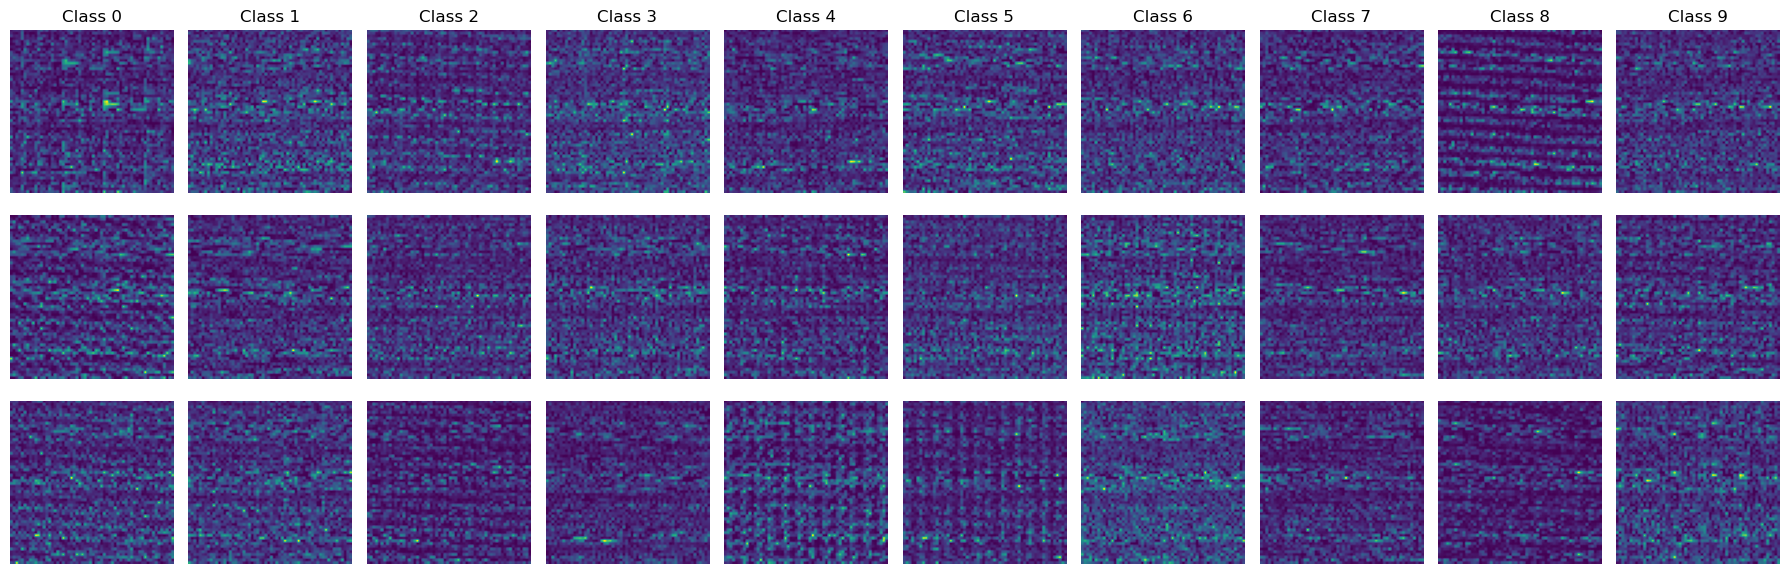

In [4]:
plot_features(Xtr_features, Ytr)

### 1.2.2. Convolution x Pooling (3D)

As our exploration progressed, we aimed to further enhance our classification performance by transitioning to 3D feature extraction. For this purpose, we introduced the `FeatureExtractor3D` class. This class expands the functionalities of its 2D equivalent by conducting convolution and pooling operations across the depth of input images. Through techniques like volume-wise convolution and pooling, our objective was to capture more complex patterns and features present in the images.

Although this method necessitated a longer computation time, it enabled us to investigate the possibility of enhancing classification performance by integrating more comprehensive feature representations.

In [5]:
#Xtr_features_3D, Xte_features_3D = data_features_3D(Xtr, Xte, load=False)
Xtr_features_3D, Xte_features_3D = data_features_3D(Xtr, Xte)

Following the same logic as before, we proceeded to visualize the features associated with each class.

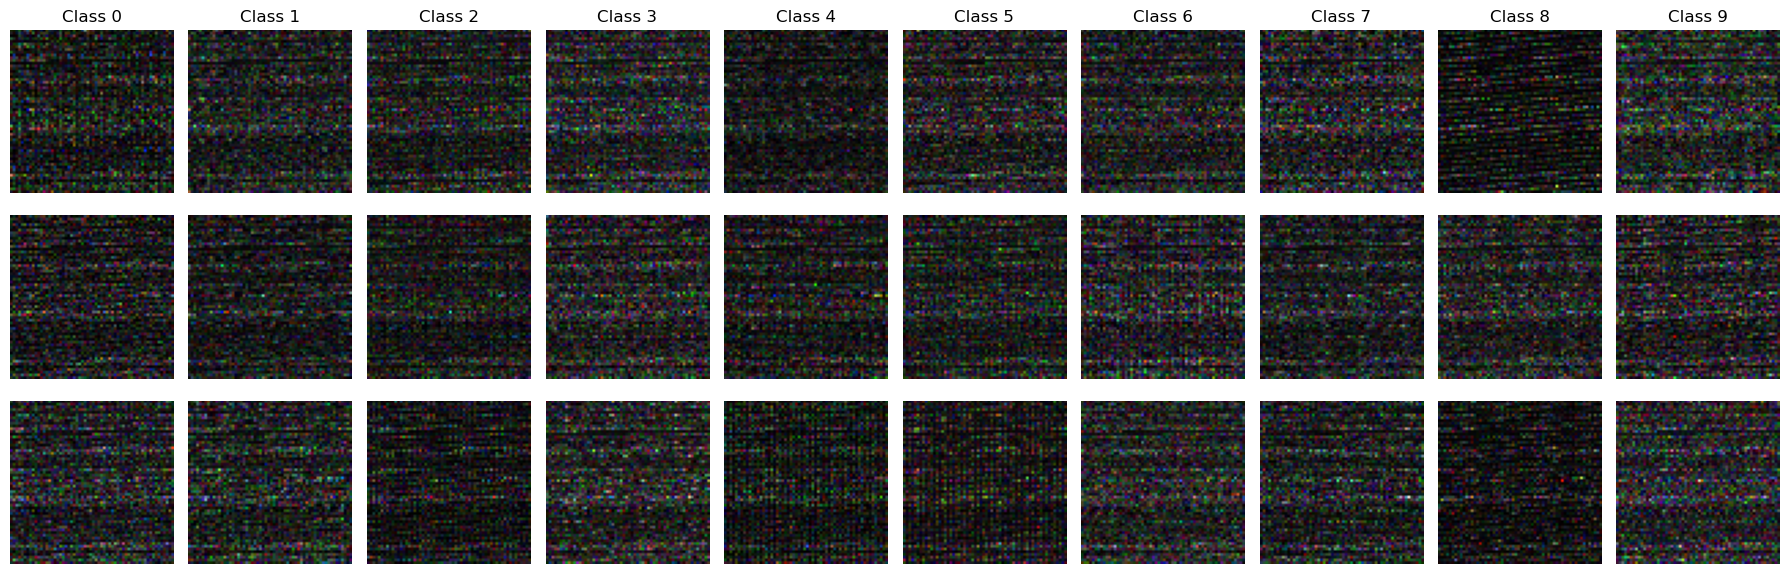

In [6]:
plot_features(Xtr_features_3D, Ytr, dim=3)

### 1.2.3. Principal Component Analysis (PCA)

So, to save time, especially when our initial method wasn't as effective, we switched to a more traditional approach. We used Kernel PCA, a method commonly taught in class, but this time on the 3D features we already had, not the original images.

In [7]:
%%time
Xtr_features_3D_pca, Xte_features_3D_pca = data_pca(Xtr_features_3D, Xte_features_3D, 1728)

CPU times: total: 36min 30s
Wall time: 10min 16s


## 1.3. Stratified Train-Test Split

In machine learning, a stratified train-test split ensures that the distribution of classes remains consistent between the training and testing sets. This method is essential for obtaining reliable performance estimates, especially with imbalanced datasets. The `stratified_train_test_split` function provided here facilitates this process, ensuring fair and accurate model evaluation.

In [8]:
# ConvPool2D
X_train_features, X_val_features, Y_train_features, Y_val_features = stratified_train_test_split(Xtr_features, Ytr)
# ConvPool3D
X_train_features_3D, X_val_features_3D, Y_train_features_3D, Y_val_features_3D = stratified_train_test_split(Xtr_features_3D, Ytr)
# PCA
X_train_features_3D_pca, X_val_features_3D_pca, Y_train_features_3D_pca, Y_val_features_3D_pca = stratified_train_test_split(Xtr_features_3D_pca, Ytr)

*Note: Due to the extensive computation time required, traditional cross-validation for hyperparameter selection is impractical. Instead, we'll rely on a single train-test split for model evaluation. The dataset's balanced distribution ensures this approach provides a reasonable estimate of model performance.*

# 2. Kernel Methods

Kernel methods offer a powerful approach for modeling data in classification tasks characterized by complex and non-linear feature relationships. By transforming input features into a higher-dimensional space, these techniques enhance the feasibility of achieving linear separation. The essence of kernel methods lies in computing the similarity, or "kernel", between pairs of data points in the input space, facilitating classification within a transformed feature space.

## 2.1. Kernels

In the context of classification tasks using kernel methods, selecting the appropriate kernel function is pivotal for achieving optimal model performance and effectively capturing complex data relationships. Here, we introduce several common kernel functions utilized in kernel-based classifiers.

### 2.1.1. Linear Kernel

The linear kernel, represented by the `LinearKernel` class, is a fundamental kernel that computes the dot product between feature vectors. It is well-suited for linearly separable datasets where classes can be distinguished by a hyperplane in the input space.

### 2.1.2. Polynomial Kernel

The polynomial kernel, embodied by the `PolynomialKernel` class, extends the linear kernel by introducing polynomial terms. With adjustable parameters for degree and coefficient, this kernel can capture non-linear relationships between features, making it suitable for datasets with curved decision boundaries.

### 2.1.3. Gaussian Kernel

The Gaussian kernel, implemented in the `GaussianKernel` class, calculates the similarity between data points based on their Euclidean distance in the input space. By using a radial basis function, this kernel can capture complex non-linear relationships and is effective in scenarios where the decision boundary is not easily delineated by a linear or polynomial function.

### 2.1.4. Sigmoid Kernel

The sigmoid kernel, encapsulated in the `SigmoidKernel` class, employs a hyperbolic tangent function to measure the similarity between feature vectors. While less commonly used compared to other kernels, it can be advantageous in scenarios where the data exhibits sigmoidal patterns.

### 2.1.5. Gaussian Polynomial Kernel

Combining the strengths of the Gaussian and polynomial kernels, the Gaussian polynomial kernel, represented by the `GaussianPolynomialKernel` class, offers a hybrid approach. By incorporating both Gaussian and polynomial terms, this kernel can capture diverse patterns present in the data, making it versatile for a wide range of classification tasks.

## 2.2. One-vs-Rest (OvR) strategy 

In multi-class classification scenarios, the One-vs-Rest (OvR) strategy complements kernel methods. Here, the problem is decomposed into binary classification tasks, treating each class as a separate problem. Individual classifiers are then trained to discern instances of a specific class from all others. During prediction, the highest score from the classifiers determines the assigned class. Through the integration of kernel methods and the OvR strategy, accurate predictions in multi-class classification tasks with non-linear decision boundaries are achievable across diverse domains.

## 2.3. Kernel Ridge Regression (KRR)

Kernel Ridge Regression (KRR) enhances linear regression by integrating kernel functions to handle intricate data relationships. By mapping features into higher-dimensional spaces, KRR allows for more adaptable decision boundaries, beneficial in complex data scenarios.

In classification tasks, KRR, coupled with the OvR strategy, predicts class labels using diverse kernel functions. Our `KernelRidgeRegression` class facilitates model training with various kernels, generating predictions for test data. Additionally, the `parameters_krr` function optimizes hyperparameters like the regularization parameter, refining classifier performance. 

*Note: Kernel parameters have been optimized beforehand through an extensive process.*

### 2.3.1. 2D Data

In [9]:
#kernels_krr, best_lambdas = parameters_krr(X_train_features, X_val_features, Y_train_features, Y_val_features, plot=True, data_3D=False)
kernels_krr, best_lambdas = parameters_krr(X_train_features, X_val_features, Y_train_features, Y_val_features, data_3D=False)

<img src="lambdas_krr.png" alt="Score vs. Lambda" width="700"/>

After regularization optimization, the polynomial and Gaussian kernels, along with their combination, emerged as effective in capturing data patterns. The polynomial kernel excelled in modeling complex non-linear relationships, while the Gaussian kernel demonstrated proficiency in capturing both local and global patterns. Given its strong performance and pattern capturing abilities, we've chosen the Gaussian kernel for prediction in our classification task.

In [10]:
%%time

lam = best_lambdas[2]
kernel = kernels_krr[2]
application_krr(Xtr_features, Xte_features, Ytr, lam, kernel, data_3D=False)

Prediction done
CPU times: total: 40.8 s
Wall time: 13.1 s


<div style="background-color: darkcyan; color: white; padding: 10px; border-radius: 5px; text-align: center;">
    <h4>Kaggle Private Score: 0.446 (Public: 0.426)</h4>
</div>

The classification performance, as indicated by the obtained scores, can be characterized as moderate, exceeding the baseline threshold. However, there remains ample opportunity for improvement, particularly in addressing the utilization of 3D features.

### 2.3.2. 3D Data

In [11]:
#kernels_krr_3D, best_lambdas_3D = parameters_krr(X_train_features_3D, X_val_features_3D, Y_train_features_3D, Y_val_features_3D, plot=True)
kernels_krr_3D, best_lambdas_3D = parameters_krr(X_train_features_3D, X_val_features_3D, Y_train_features_3D, Y_val_features_3D)

<img src="lambdas_krr_3D.png" alt="Score vs. Lambda" width="700"/>

The results show an overall improvement compared to previous performances, with the exception of the sigmoid kernel. Additionally, the Gaussian kernel maintained its slight edge over the other kernels, confirming its effectiveness for making predictions.

In [12]:
%%time

lam_3D = best_lambdas_3D[2]
kernel_3D = kernels_krr_3D[2]
application_krr(Xtr_features_3D, Xte_features_3D, Ytr, lam_3D, kernel_3D)

Prediction done
CPU times: total: 1min 55s
Wall time: 33.8 s


<div style="background-color: darkcyan; color: white; padding: 10px; border-radius: 5px; text-align: center;">
    <h4>Kaggle Private Score: 0.45 (Public: 0.445)</h4>
</div>

Based on the obtained scores, we can conclude that there was a slight improvement in performance compared to the previous results. However, the improvement is marginal, indicating that further optimization or exploration of different techniques may be necessary to achieve more significant enhancements in classification accuracy.

## 2.4. Kernel Logistic Regression (KLR)

Kernel Logistic Regression (KLR) extends logistic regression by incorporating kernel methods, making it suitable for non-linear classification tasks. The class `KernelLogisticRegression` encapsulates the functionality of KLR, allowing for the training of classifiers using various kernel functions, such as linear, polynomial, Gaussian, sigmoid, and their combinations.

The `parameters_klr` function facilitates the optimization of hyperparameters, such as the regularization parameter ($\lambda$), for each kernel function. It evaluates different lambda values and kernel types to determine the optimal configuration for the classifier. Additionally, the `application_klr` function applies KLR to the test dataset, generating predictions for submission to Kaggle.

However, initial tests revealed that KLR did not outperform KRR in terms of classification accuracy. As a result, we opted to use the features obtained through PCA for the final submission, demonstrating the exploration of alternative methods while ultimately selecting the most effective approach for the task at hand.

In [13]:
#kernels_klr, best_lambdas_klr = parameters_klr(X_train_features_3D_pca, X_val_features_3D_pca, Y_train_features_3D_pca, Y_val_features_3D_pca, plot=True)
kernels_klr, best_lambdas_klr = parameters_klr(X_train_features_3D_pca, X_val_features_3D_pca, Y_train_features_3D_pca, Y_val_features_3D_pca)

<img src="lambdas_klr.png" alt="Score vs. Lambda" width="700"/>

The validation results for the linear kernel appear promising, surpassing the performance of other kernels.

In [14]:
%%time

lam_klr = best_lambdas_klr[2]
kernel_klr = kernels_klr[2]
application_klr(Xtr_features_3D_pca, Xte_features_3D_pca, Ytr, lam_klr, kernel_klr)

Prediction done
CPU times: total: 6min 27s
Wall time: 2min 22s


<div style="background-color: brown; color: white; padding: 10px; border-radius: 5px; text-align: center;">
    <h4>Kaggle Private Score: 0.084 (Public: 0.105)</h4>
</div>

However, the validation results proved to be misleading. Accuracies on the test set unexpectedly dropped, yet the Gaussian kernel demonstrated superior performance.

## 2.5. Kernel k Nearest Neigbors (KNN)

Kernel k Nearest Neighbors (KNN) is a non-parametric classification algorithm that assigns a class label to a data point based on the majority class of its k nearest neighbors. The class `KernelKNN` extends traditional KNN by incorporating kernel methods, allowing for non-linear classification boundaries.

The `parameters_knn` function facilitates the optimization of hyperparameters, particularly the choice of the number of nearest neighbors (k), for each kernel function. It evaluates different k values and kernel types to determine the optimal configuration for the classifier. The `application_knn` function applies Kernel KNN to the test dataset, generating predictions for submission. 

In [15]:
#kernels_knn, best_k = parameters_knn(Xtr_features_3D, X_train_features_3D, X_val_features_3D, Y_train_features_3D, Y_val_features_3D, plot=True)
kernels_knn, best_k = parameters_knn(Xtr_features_3D, X_train_features_3D, X_val_features_3D, Y_train_features_3D, Y_val_features_3D)

<img src="lambdas_knn.png" alt="Score vs. k" width="700"/>

Following the fine-tuning of hyperparameters, the curves reveal lower-than-expected accuracies, although the Gaussian kernel exhibits a slight edge.

In [16]:
%%time

k = best_k[2]
kernel = kernels_knn[2]
application_knn(Xtr_features_3D, Xte_features_3D, Ytr, k, kernel)

Prediction done
CPU times: total: 2min 19s
Wall time: 40.9 s


<div style="background-color: orange; color: white; padding: 10px; border-radius: 5px; text-align: center;">
    <h4>Kaggle Private Score: 0.186 (Public: 0.209)</h4>
</div>

Based on these results, it seems that Kernel KNN might not be the most suitable approach for our classification task. Further investigation and experimentation with alternative classification algorithms or feature representations may be required to enhance the performance of the classifier.

## 2.6. Kernel Support Vector Machines (SVM)

Support Vector Machines (SVM) are powerful supervised learning algorithms used for classification and regression tasks. SVMs excel in scenarios where data points are not linearly separable in their original feature space. The `KernelSVM` class in our implementation encapsulates SVM functionality, offering flexibility with various kernel functions for capturing complex data relationships.

To optimize SVM performance, the `parameters_svm` function helps select the optimal regularization parameter. Then, the `application_svm` function applies the trained SVM model to predict class labels for test data. 

*SVMs find wide application in image and text classification, as well as bioinformatics, thanks to their effectiveness in handling high-dimensional and nonlinear data relationships.*

In [17]:
# Best validation results 
#kernel_SVM = GaussianKernel(sigma=0.7743)

# Best test results
kernel_SVM = GaussianKernel(sigma=0.5995)

#C_SVM = parameters_svm(X_train_features_3D, X_val_features_3D, Y_train_features_3D, Y_val_features_3D, kernel=kernel_SVM, plot=True)
C_SVM = parameters_svm(X_train_features_3D, X_val_features_3D, Y_train_features_3D, Y_val_features_3D, kernel=kernel_SVM)

<img src="C_svm.png" alt="Score vs. C" width="700"/>

Due to the long execution time in this case, we opted for the Gaussian kernel, which exhibited superior performance across all methods.

In [18]:
%%time
application_svm(Xtr_features_3D, Xte_features_3D, Ytr, C_SVM, kernel_SVM)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Prediction:   0%|          | 0/10 [00:00<?, ?it/s]

Prediction done
CPU times: total: 30min 54s
Wall time: 35min 52s


<div style="background-color: green; color: white; padding: 10px; border-radius: 5px; text-align: center;">
    <h4>Kaggle Private Score: 0.458 (Public: 0.439)</h4>
</div>

Despite the initial impression from the public score favoring KRR, SVM slightly outperformed it across the entire test set, positioning both methods above the others.

# Conclusion

In our project, we explored how well kernel methods work for classifying images. By studying techniques like Kernel Ridge Regression (KRR), Kernel Logistic Regression (KLR), Kernel k Nearest Neighbors (KNN), and Support Vector Machines (SVM), we learned about their performance. While SVM and KRR showed promise, KNN and KLR had some trouble capturing complex patterns in the data. Further analysis and optimization may be necessary to improve their effectiveness.

### References

Michael Arbel. (2024). Data Challenge - Kernel methods (2023-2024). Kaggle. [link](https://kaggle.com/competitions/data-challenge-kernel-methods-2023-2024)

Jason Brownlee. (2021, April 27). One-vs-Rest and One-vs-One for Multi-Class Classification. [link](https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/)